In [39]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import urllib.request
from transformers import BertTokenizer
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
from transformers import TFBertForSequenceClassification
from sklearn.metrics import confusion_matrix
import seaborn as sns

## 뉴스감정 데이터 셋 다운로드
- 언어: 영어, 한국어
- 데이터 건수: 4,846건
- 감정 라벨: positive, neutral, negative
- 영문 데이터: 16명의 전문 연구자가 수동으로 라벨링하여 생성(Finance Phrase Bank (Malo et al., 2014))
- 한국어 데이터: 영문 데이터를 한국어로 번역한 후 검수를 거쳐 추가(https://github.com/ukairia777/finance_sentiment_corpus)


In [40]:
# 데이터셋 URL과 저장 경로 설정
DATASET_URL = "https://raw.githubusercontent.com/ukairia777/finance_sentiment_corpus/main/finance_data.csv"
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), "../"))
DATASET_DIR = os.path.join(BASE_DIR, "data")
DATASET_NAME = os.path.join(DATASET_DIR, "finance_news_data.csv")

# 저장 경로에 디렉터리가 없으면 생성
os.makedirs(DATASET_DIR, exist_ok=True)

# 데이터셋 다운로드
urllib.request.urlretrieve(DATASET_URL, filename=DATASET_NAME)

('C:\\Users\\kg200\\Desktop\\StockSentimentPredictor\\data\\finance_news_data.csv',
 <http.client.HTTPMessage at 0x1d122cda880>)

## 데이터 셋 확인 및 전처리
- `sentence` 열 삭제(영문 뉴스 제거)
- 감정 레이블 숫자 치환 (0:negative ,1:neutral ,2:positive)
- 결측값 여부 및 `kor_sentence`열의 고유한 값의 개수 확인
- `kor_sentence` 기준으로 중복 제거

In [41]:
# 데이터 셋 확인
dataset = pd.read_csv(DATASET_NAME)

print('총 데이터 수: ',len(dataset), "\n")
print('원본 데이터')
dataset

총 데이터 수:  4846 

원본 데이터


,labels,sentence,kor_sentence
0,neutral,"According to Gran, the company has no plans to...","Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,neutral,Technopolis plans to develop in stages an area...,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,negative,The international electronic industry company ...,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,positive,With the new production plant the company woul...,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,positive,According to the company's updated strategy fo...,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."
...,...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...,런던 마켓워치 -- 은행주의 반등이 FTSE 100지수의 약세를 상쇄하지 못하면서 ...
4842,neutral,Rinkuskiai's beer sales fell by 6.5 per cent t...,린쿠스키아의 맥주 판매량은 416만 리터로 6.5% 감소했으며 카우노 알루스의 맥주...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...,"영업이익은 2007년 68.8 mn에서 35.4 mn으로 떨어졌으며, 선박 판매 이..."
4844,negative,Net sales of the Paper segment decreased to EU...,페이퍼 부문 순매출은 2008년 2분기 241.1 mn에서 2009년 2분기 221...


In [42]:
# 'sentence' 열 삭제(영문 뉴스 제거)
del dataset['sentence']

# 감정 레이블 숫자 치환
dataset['labels'] = dataset['labels'].replace(['negative', 'neutral', 'positive'], [0, 1, 2])

print('영문 뉴스 제거 및 감정 레이블 숫자 치환 데이터')
dataset

영문 뉴스 제거 및 감정 레이블 숫자 치환 데이터


,labels,kor_sentence
0,1,"Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,1,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,0,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,2,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,2,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."
...,...,...
4841,0,런던 마켓워치 -- 은행주의 반등이 FTSE 100지수의 약세를 상쇄하지 못하면서 ...
4842,1,린쿠스키아의 맥주 판매량은 416만 리터로 6.5% 감소했으며 카우노 알루스의 맥주...
4843,0,"영업이익은 2007년 68.8 mn에서 35.4 mn으로 떨어졌으며, 선박 판매 이..."
4844,0,페이퍼 부문 순매출은 2008년 2분기 241.1 mn에서 2009년 2분기 221...


In [35]:
# 데이터 셋
print('데이터 요약')
dataset.info()

print('\n결측값 여부 :',dataset.isnull().values.any(), '\n')

print('kor_sentence 열의 유니크한 값 :',dataset['kor_sentence'].nunique(), '\n')

# 'kor_sentence' 기준으로 중복 제거
dataset = dataset[~dataset['kor_sentence'].duplicated()]

print('총 데이터 수 :',len(dataset))

데이터 요약
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   labels        4846 non-null   int64 
 1   kor_sentence  4846 non-null   object
dtypes: int64(1), object(1)
memory usage: 75.8+ KB

결측값 여부 : False 

kor_sentence 열의 유니크한 값 : 4827 

총 데이터 수 : 4827


## 데이터 셋 감정 레이블 분포 확인
- `barplot`을 사용하여 감정 레이블의 분포를 시각화

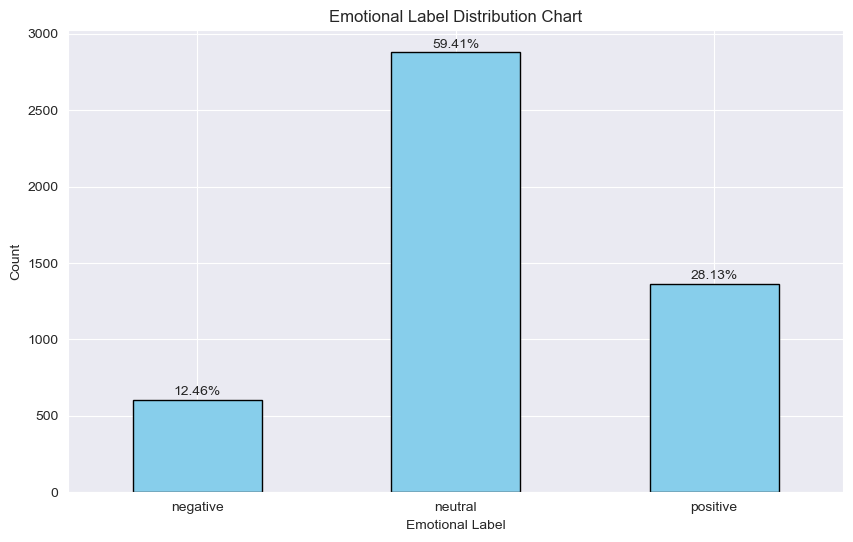

In [44]:
# 라벨 분포 시각화
plt.figure(figsize=(10, 6))
label_counts = dataset['labels'].value_counts()
label_counts = label_counts.loc[[0, 1, 2]].fillna(0).astype(int)
bar_plot = label_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# 제목 및 축 레이블 설정
plt.title('Emotional Label Distribution Chart')
plt.xlabel('Emotional Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=['negative', 'neutral', 'positive'], rotation=0)

# 비율 표기
total = label_counts.sum()
for i, value in enumerate(label_counts):
    percentage = (value / total) * 100
    plt.text(i, value + 10, f'{percentage:.2f}%', ha='center', va='bottom', fontsize=10)

plt.show()

## 데이터의 불균형 해결
- 감정 레이블 분포를 확인 한 결과, 데이터에 불균형 문제 발견
- 데이터 셋을 훈련 데이터(80%)와 테스트 데이터(20%) 분리
- 훈련 데이터의 감정 레이블 비율에 따라 적절한 클래스 가중치를 계산하여, 학습 시 불균형 문제를 완화

In [45]:
# 데이터셋 분리
train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)

# 클래스 가중치 계산
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data['labels']),
    y=train_data['labels']
)

# 클래스 가중치 딕셔너리로 변환
class_weight_dict = dict(enumerate(class_weights))

# 가중치 확인
print(class_weight_dict)

{0: 2.6153846153846154, 1: 0.5597920277296361, 2: 1.2029795158286778}


## 모델과 토크나이저 설정 및 데이터 전처리
- 감정 분석을 위해 양방향 모델 `BERT`를 사용하여 뉴스 기사의 문맥을 효과적 이해
- 한국어의 문법적 특성에 맞춰 학습된 `KLUE BERT` 모델을 활용하여 한국어 데이터를 처리
- 데이터 전처리 과정에서 토크나이저를 사용해 문장을 정수 인코딩하고, 패딩 및 트리밍을 적용하여 BERT 모델에 적합한 형태로 변환
- BERT 모델의 사전 학습된 가중치를 사용하여 뉴스 문장들을 효율적으로 벡터화하고, 이후 훈련 및 검증을 위한 데이터셋을 구성

In [46]:
# 모델과 토크나이저 설정
MODEL_NAME = "klue/bert-base"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

# 데이터 전처리 함수 정의
def encode_data(data):
    return tokenizer(
        data['kor_sentence'].tolist(),
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="tf"
    )

# 데이터 전처리
train_encodings = encode_data(train_data)
val_encodings = encode_data(val_data)

# TensorFlow Dataset 생성
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_data['labels'].tolist())).shuffle(1000).batch(16)
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_data['labels'].tolist())).batch(16)

D:\Anaconda\envs\stock_sentiment_predictor\lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## 모델 학습

- 모델 학습 중 성능 향상 및 최적화를 위한 콜백 함수 정의 
    - `ModelCheckpoint`를 통해 가장 성능이 좋은 모델 저장
    - `EarlyStopping`으로 검증 정확도가 개선되지 않으면 학습 중단
    - `ReduceLROnPlateau`를 통해 검증 손실이 개선되지 않으면 학습률 감소

In [47]:
# BERT 모델 불러오기
model = TFBertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3,
    hidden_dropout_prob=0.2,
    attention_probs_dropout_prob=0.3
)

# 콜백 함수 정의 (EarlyStopping)
callbacks = [
    EarlyStopping(monitor='val_loss', min_delta=0.001, patience=2),
]

# 모델 학습 준비 (Adam 옵티마이저, 손실 함수 설정)
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# 모델 학습
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    class_weight=class_weight_dict,
    callbacks=callbacks
)

D:\Anaconda\envs\stock_sentiment_predictor\lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequence

Epoch 1/10
243/243 [==============================] - 116s 412ms/step - loss: 0.6143 - accuracy: 0.7227 - val_loss: 0.4936 - val_accuracy: 0.7928
Epoch 2/10
243/243 [==============================] - 97s 397ms/step - loss: 0.3533 - accuracy: 0.8380 - val_loss: 0.4076 - val_accuracy: 0.8412
Epoch 3/10
243/243 [==============================] - 94s 385ms/step - loss: 0.2645 - accuracy: 0.8775 - val_loss: 0.4377 - val_accuracy: 0.8443
Epoch 4/10
243/243 [==============================] - 96s 396ms/step - loss: 0.1954 - accuracy: 0.9138 - val_loss: 0.4495 - val_accuracy: 0.8495


## 학습 결과 시각화
- `seaborn`의 `heatmap`을 사용하여 모델의 학습 결과를 혼동 행렬로 시각화

61/61 [==============================] - 10s 109ms/step


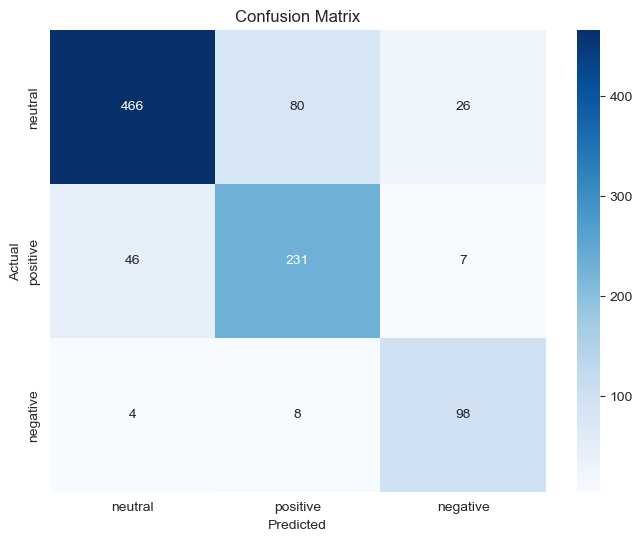

In [10]:
# 예측 및 혼동 행렬 계산
val_predictions = model.predict(val_dataset)
val_pred_classes = np.argmax(val_predictions.logits, axis=1)

# 혼동 행렬
conf_matrix = confusion_matrix(val_data['labels'], val_pred_classes)

# 혼동 행렬 시각화
def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['neutral', 'positive', 'negative'],
                yticklabels=['neutral', 'positive', 'negative'])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

plot_confusion_matrix(conf_matrix)

## 검증 데이터에 대한 모델 평가

In [11]:
# 모델 평가
loss, accuracy = model.evaluate(val_dataset, batch_size=1024)

print(f"손실: {loss:.4f}")
print(f"정확도: {accuracy:.4f}")

61/61 [==============================] - 7s 109ms/step - loss: 0.5890 - accuracy: 0.8230
손실: 0.5890
정확도: 0.8230


## 최종 모델과 토크나이저 저장

In [12]:
# 학습 완료 후 모델 저장
model.save_pretrained("../sentiment_analysis_model")
tokenizer.save_pretrained("../sentiment_analysis_model")

('../sentiment_analysis_model\\tokenizer_config.json',
 '../sentiment_analysis_model\\special_tokens_map.json',
 '../sentiment_analysis_model\\vocab.txt',
 '../sentiment_analysis_model\\added_tokens.json')